<a href="https://colab.research.google.com/github/CarolinRi/CorneaAI/blob/main/Clustering_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install data-science-utils

In [15]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer

from sklearn.decomposition import PCA as sklearnPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from pandas.plotting import parallel_coordinates

from ds_utils.unsupervised import plot_cluster_cardinality
from ds_utils.unsupervised import plot_cluster_magnitude
from scipy.spatial.distance import euclidean
from ds_utils.unsupervised import plot_magnitude_vs_cardinality

from sklearn import metrics
from sklearn.metrics import pairwise_distances

from google.colab import drive


In [16]:
#loading data from github
url = 'https://raw.githubusercontent.com/CarolinRi/CorneaAI/main/Corneae.csv'
data = pd.read_csv(url)

# data.head()
# print(data.columns)

                Sa           Sz          Str          Sdr           Sq  \
count  2789.000000  2789.000000  2789.000000  2789.000000  2789.000000   
mean      0.268867    11.354773     0.615787     0.049060     0.419154   
std       0.413539    29.067397     0.183144     0.298394     0.721742   
min       0.015000     0.156000     0.017000     0.000014     0.019000   
25%       0.130000     3.944000     0.521000     0.004482     0.182000   
50%       0.175000     5.526000     0.634000     0.010570     0.244000   
75%       0.270000     8.953000     0.744000     0.027740     0.388000   
max       7.787000   611.869000     0.981000     8.331000    11.129000   

               Ssk          Sku           Sp           Sv          Sal  ...  \
count  2789.000000  2789.000000  2789.000000  2789.000000  2789.000000  ...   
mean      0.994057    26.291687     6.076081     5.278683     9.954632  ...   
std       2.360562    65.372319    16.691751    13.586484     4.107003  ...   
min     -26.94100

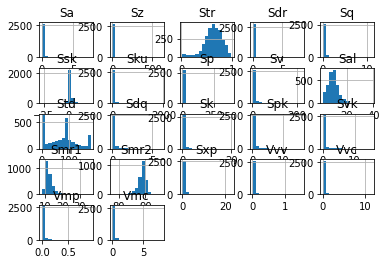

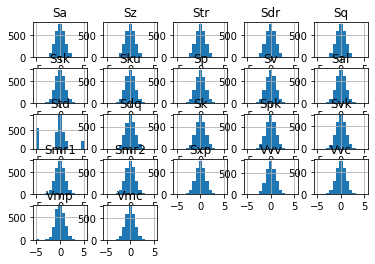

In [18]:
export_0 = True

# 22 features
to_keep = ['Sa', 'Sz', 'Str', 'Sdr', 'Sq', 'Ssk', 'Sku', 'Sp', 'Sv', 'Sal','Std','Sdq','Sk', 'Spk', 'Svk', 'Smr1', 'Smr2', 'Sxp', 'Vvv', 'Vvc', 'Vmp', 'Vmc']
# 21 features: Std eliminated
# to_keep = ['Sa', 'Sz', 'Str', 'Sdr', 'Sq', 'Ssk', 'Sku', 'Sp', 'Sv', 'Sal','Sdq','Sk', 'Spk', 'Svk', 'Smr1', 'Smr2', 'Sxp', 'Vvv', 'Vvc', 'Vmp', 'Vmc']
# 9 features
# to_keep = ['Str','Sdr','Sq','Ssk','Sku','Sal','Std','Smr1','Smr2']
# 8 features: Std eliminated
# to_keep = ['Str','Sdr','Sq','Ssk','Sku','Sal','Smr1','Smr2']

# Dataframe containing the features to be analyzed
df_evidence = data[to_keep]

# export to google drive
if export_0 is True:

  path = '/content/drive/My Drive/data_initial.csv'
  with open(path, 'w', encoding = 'utf-8-sig') as f:
    df_evidence.to_csv(f)

#plot histograms of unscaled data
df_evidence.hist(bins=15)

# analyze data composition
evidence_desc = df_evidence.describe()
print(evidence_desc)

# export to google drive
if export_0 is True:

  path = '/content/drive/My Drive/evidence_initial.csv'
  with open(path, 'w', encoding = 'utf-8-sig') as f:
    evidence_desc.to_csv(f)

# convert dataframe to numpy
evidence = df_evidence.values.tolist()

# scale features
# scaler = MinMaxScaler()
# scaler = StandardScaler()
# scaler = RobustScaler()
# scaler = PowerTransformer()
scaler = QuantileTransformer(output_distribution="normal")
evidence = scaler.fit_transform(evidence)

# convert scaled evidence to DataFrame
df_evidence_sc = pd.DataFrame(evidence, columns = df_evidence.columns)
# print(df_evidence_sc)

# export to google drive
if export_0 is True:

  path = '/content/drive/My Drive/data_scaled.csv'
  with open(path, 'w', encoding = 'utf-8-sig') as f:
    df_evidence_sc.to_csv(f)

#plot histograms of unscaled data
df_evidence_sc.hist(bins=15)

# analyze scaled data composition
evidence_sc_desc = df_evidence_sc.describe()

# export to google drive
if export_0 is True:

  path = '/content/drive/My Drive/evidence_scaled.csv'
  with open(path, 'w', encoding = 'utf-8-sig') as f:
    evidence_sc_desc.to_csv(f)

print(evidence_sc_desc)

labels = data['name']
labels = labels.values.tolist()


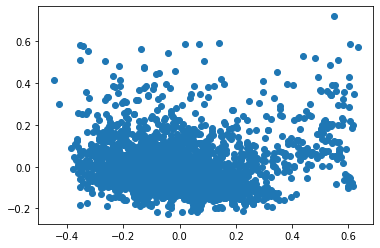

In [ ]:
# principal component analysis

pca = sklearnPCA(n_components=2) #2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(evidence.copy()))
plt.scatter(transformed[:][0],transformed[:][1])


**1. K means clustering**

- centroid-based

1.1 Elbow method to identify the optimal number of clusters

The number of clusters is varied from 1 to 10 and the WCSS (Within-Cluster Sum of Square) wird berechnet. Die Elbow-shaped Kurve hat einen Punkt, an dem sich die Steigung der Kurven drastisch ändert. Dieser Punkt, der "Ellenbogen", wird als die ideale Anzahl an Clustern gesehen.

1.2 Generate model and plot cluster result in reduced dimensions

1.3 Get evaluation metrics

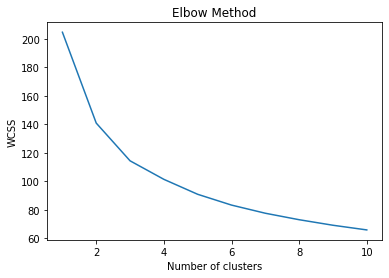

In [ ]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=None)
    kmeans.fit(evidence)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

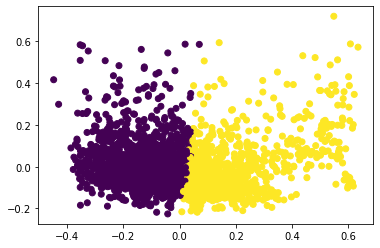

In [ ]:
# performing k means clustering with n clusters
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=None)
pred_y_kmeans = kmeans.fit(evidence)

# print(pred_y_kmeans.labels_)

# distances = pred_y_kmeans.transform(evidence)

# print(distances)

# centers = kmeans.cluster_centers_
# transformed_centers = pca.transform(centers)
plt.scatter(transformed[:][0],transformed[:][1],c=pred_y_kmeans.labels_.astype(float))
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

**1. Cluster cardinality**

Cluster cardinality is the number of examples per cluster

**2. Cluster magnitude**

Cluster magnitude is the sum of distances from all examples to the centroid of the cluster.

**3. Silhouette Coefficient**

high coeff: well defined clusters

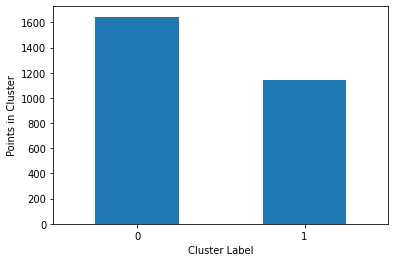

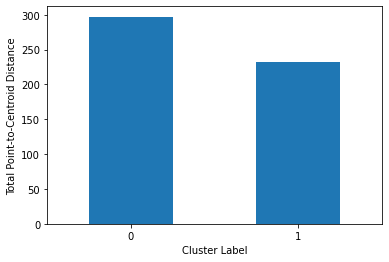

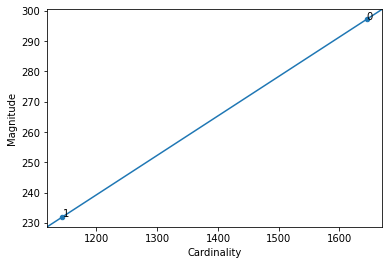

0.3050421046208071 1261.1000185552002 1.2475023624459474


In [ ]:
plot_cluster_cardinality(pred_y_kmeans.labels_)

plot_cluster_magnitude(evidence, pred_y_kmeans.labels_, pred_y_kmeans.cluster_centers_,euclidean)

plot_magnitude_vs_cardinality(evidence, pred_y_kmeans.labels_, pred_y_kmeans.cluster_centers_, euclidean)

plt.show()

# metrics.silhouette_score(evidence, pred_y.labels_, metric='euclidean')

Sil_kmeans = metrics.silhouette_score(evidence, pred_y_kmeans.labels_, metric='euclidean')
CH_kmeans = metrics.calinski_harabasz_score(evidence, pred_y_kmeans.labels_)
DB_kmeans = metrics.davies_bouldin_score(evidence, pred_y_kmeans.labels_)

print(Sil_kmeans, CH_kmeans, DB_kmeans)

**Export the mean value and std of each feature grouped by clusters**



In [ ]:
export_1 = True

data_forplot = data[to_keep].copy()

data_forplot['labels'] = pred_y_kmeans.labels_

# print(data_forplot)

data_bylabel = data_forplot.groupby(by='labels')

avg_vals = data_bylabel.mean()
std_vals = data_bylabel.std()

print(avg_vals)
print(std_vals)

if export_1 is True:

  from google.colab import drive

  drive.mount('/content/drive')
  path = '/content/drive/My Drive/mean_vals.csv'
  with open(path, 'w', encoding = 'utf-8-sig') as f:
    avg_vals.to_csv(f)

    path = '/content/drive/My Drive/std_vals.csv'
  with open(path, 'w', encoding = 'utf-8-sig') as f:
    std_vals.to_csv(f)



             Str       Ssk        Sku        Sal       Smr1       Smr2  \
labels                                                                   
0       0.732309  1.253619  27.314550  11.188247  12.519382  88.897421   
1       0.448237  0.620823  24.820875   8.180770  12.338163  88.402458   

              Sq       Sdr  
labels                      
0       0.411207  0.044056  
1       0.430580  0.056255  
             Str       Ssk        Sku       Sal      Smr1      Smr2        Sq  \
labels                                                                          
0       0.094352  2.245574  55.647465  3.993997  2.139816  1.651265  0.798547   
1       0.146191  2.470334  77.242259  3.586007  2.412406  1.872949  0.594305   

             Sdr  
labels            
0       0.244870  
1       0.361734  
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Export a sorted list of samples closest to each clusters centroid**

In [ ]:
export_2 = True

sorting_result = {}

for i in range(0,len(pred_y_kmeans.cluster_centers_)):

  distances = kmeans.transform(evidence)[:,i]

  # print(list(zip(distances, data['name'])))

  # new_dist, new_labels = zip(*sorted(zip(distances, data['name'])))

  new_dist, new_labels = (list(t) for t in zip(*sorted(zip(distances, data['name']))))

  print(new_dist)
  print(new_labels)

  sorting_result[f'distances cluster {i+1}'] = new_dist
  sorting_result[f'names {i+1}'] = new_labels


# ind = np.argsort(d)[::-1][:50]

if export_2 is True:

  from google.colab import drive

  dataframe = pd.DataFrame.from_dict(sorting_result)

  drive.mount('/content/drive')
  path = '/content/drive/My Drive/output.csv'
  with open(path, 'w', encoding = 'utf-8-sig') as f:
    dataframe.to_csv(f)


[0.04593206719892634, 0.04763080435937563, 0.05397912369005263, 0.054615102370579136, 0.0562930365632514, 0.05644664434354783, 0.056754772402843726, 0.05681005051839965, 0.058288523151822945, 0.0584186812251347, 0.05849287737285005, 0.05972710942964502, 0.06064109305709457, 0.06250726219847864, 0.0629278931201715, 0.0641132031515083, 0.06438739709619598, 0.06444424690590511, 0.06468310235100366, 0.06469903547550317, 0.06470565442900814, 0.06559951189629441, 0.06607432285123575, 0.06656783525760479, 0.06710678056039915, 0.0671741540254741, 0.06745235833848112, 0.0676244916366576, 0.06764966170848138, 0.06773981586902647, 0.06824082261804723, 0.06895969272042846, 0.06910330543592524, 0.06965093009009515, 0.06967686302268107, 0.07005256231766814, 0.07015504399675433, 0.07094967046030874, 0.07110558359063, 0.07149239912880667, 0.07170028105075768, 0.07172748194604557, 0.07242003365869767, 0.07255240824644402, 0.07261855887632486, 0.07308881712476381, 0.07322805181300635, 0.0732750403451055

**2. Mean-shift clustering**



In [ ]:
from sklearn.cluster import MeanShift

meanshift = MeanShift()

pred_y_meanshift = meanshift.fit(evidence)

plt.scatter(transformed[:][0],transformed[:][1],c=pred_y_meanshift.labels_.astype(float))

plt.show()

plot_cluster_cardinality(pred_y_meanshift.labels_)

plot_cluster_magnitude(evidence, pred_y_meanshift.labels_, pred_y_meanshift.cluster_centers_,euclidean)

plot_magnitude_vs_cardinality(evidence, pred_y_meanshift.labels_, pred_y_meanshift.cluster_centers_, euclidean)

plt.show()

Sil_meanshift = metrics.silhouette_score(evidence, pred_y_meanshift.labels_, metric='euclidean')
CH_meanshift = metrics.calinski_harabasz_score(evidence, pred_y_meanshift.labels_)
DB_meanshift = metrics.davies_bouldin_score(evidence, pred_y_meanshift.labels_)

print(Sil_meanshift, CH_meanshift, DB_meanshift)

**3. Spectral clustering**

In [ ]:
from sklearn.cluster import SpectralClustering

spectral = SpectralClustering(n_clusters=2, assign_labels='discretize', random_state=None)

pred_y_spectral = spectral.fit(evidence)

plt.scatter(transformed[:][0],transformed[:][1],c=pred_y_spectral.labels_.astype(float))
plt.show()

plot_cluster_cardinality(pred_y_spectral.labels_)

plt.show()

Sil_spectral = metrics.silhouette_score(evidence, pred_y_spectral.labels_, metric='euclidean')
CH_spectral = metrics.calinski_harabasz_score(evidence, pred_y_spectral.labels_)
DB_spectral = metrics.davies_bouldin_score(evidence, pred_y_spectral.labels_)

print(Sil_spectral, CH_spectral, DB_spectral)

**4. Agglomerative clustering**

In [ ]:
from sklearn.cluster import AgglomerativeClustering

agglom = AgglomerativeClustering()
pred_y_agglom = agglom.fit(evidence)

plt.scatter(transformed[:][0],transformed[:][1],c=pred_y_agglom.labels_.astype(float))
plt.show()

plot_cluster_cardinality(pred_y_agglom.labels_)

plt.show()

Sil_agglom = metrics.silhouette_score(evidence, pred_y_agglom.labels_, metric='euclidean')
CH_agglom = metrics.calinski_harabasz_score(evidence, pred_y_agglom.labels_)
DB_agglom = metrics.davies_bouldin_score(evidence, pred_y_agglom.labels_)

print(Sil_agglom, CH_agglom, DB_agglom)

**5. Gaussian mixture**

In [ ]:
from sklearn.cluster import OPTICS

optics_m = OPTICS(min_samples=10)
pred_y_optics = optics_m.fit(evidence)

plt.scatter(transformed[:][0],transformed[:][1],c=pred_y_optics.labels_.astype(float))
plt.show()

plot_cluster_cardinality(pred_y_optics.labels_)

plt.show()

Sil_optics = metrics.silhouette_score(evidence, pred_y_optics.labels_, metric='euclidean')
CH_optics = metrics.calinski_harabasz_score(evidence, pred_y_optics.labels_)
DB_optics = metrics.davies_bouldin_score(evidence, pred_y_optics.labels_)

print(Sil_optics, CH_optics, DB_optics)


**6. BIRCH**

In [ ]:
from sklearn.cluster import Birch

brc = Birch(n_clusters=None)
pred_y_brc = brc.fit(evidence)

plt.scatter(transformed[:][0],transformed[:][1],c=pred_y_brc.labels_.astype(float))
plt.show()

plot_cluster_cardinality(pred_y_brc.labels_)

plt.show()

Sil_brc = metrics.silhouette_score(evidence, pred_y_brc.labels_, metric='euclidean')
CH_brc = metrics.calinski_harabasz_score(evidence, pred_y_brc.labels_)
DB_brc = metrics.davies_bouldin_score(evidence, pred_y_brc.labels_)

print(Sil_brc, CH_brc, DB_brc)